In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import datetime as dt
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy
import netCDF4

In [3]:
# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing
# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = []
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [4]:
#institution_id="CNRM-CERFACS"
mip_era="CMIP6"
activity_id="HighResMIP"
table_id="Omon"
variable_id="tos"
experiment_id='hist-1950'
institution_id="MPI-M"
source_id="MPI-ESM1-2-HR"
grid_lbl="gn"
member_id="r1i1p1f1"
result = esgf_search(activity_id=activity_id,
                     table_id=table_id,
                     variable_id=variable_id,
                     experiment_id=experiment_id,
                     institution_id=institution_id, 
                     source_id=source_id,
                     grid_label=grid_lbl,
                     member_id=member_id)
# there are mulitple sources of the same data--need to pick one

https://esgf-node.llnl.gov/esg-search/search/?activity_id=HighResMIP&table_id=Omon&variable_id=tos&experiment_id=hist-1950&institution_id=MPI-M&source_id=MPI-ESM1-2-HR&grid_label=gn&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=HighResMIP&table_id=Omon&variable_id=tos&experiment_id=hist-1950&institution_id=MPI-M&source_id=MPI-ESM1-2-HR&grid_label=gn&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=HighResMIP&table_id=Omon&variable_id=tos&experiment_id=hist-1950&institution_id=MPI-M&source_id=MPI-ESM1-2-HR&grid_label=gn&member_id=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=HighResMIP&table_id=Omon&variable_id=tos&experiment_id=hist-1950&institution_id=MPI-M&source_id=M

In [5]:
files_to_open = result[31:]
print(files_to_open) #Si empieza en el año 1950 hasta el 1981 es 31 (indice 0)

['https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/HighResMIP/MPI-M/MPI-ESM1-2-HR/hist-1950/r1i1p1f1/Omon/tos/gn/v20191129/tos_Omon_MPI-ESM1-2-HR_hist-1950_r1i1p1f1_gn_198101-198112.nc', 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/HighResMIP/MPI-M/MPI-ESM1-2-HR/hist-1950/r1i1p1f1/Omon/tos/gn/v20191129/tos_Omon_MPI-ESM1-2-HR_hist-1950_r1i1p1f1_gn_198201-198212.nc', 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/HighResMIP/MPI-M/MPI-ESM1-2-HR/hist-1950/r1i1p1f1/Omon/tos/gn/v20191129/tos_Omon_MPI-ESM1-2-HR_hist-1950_r1i1p1f1_gn_198301-198312.nc', 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/HighResMIP/MPI-M/MPI-ESM1-2-HR/hist-1950/r1i1p1f1/Omon/tos/gn/v20191129/tos_Omon_MPI-ESM1-2-HR_hist-1950_r1i1p1f1_gn_198401-198412.nc', 'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/HighResMIP/MPI-M/MPI-ESM1-2-HR/hist-1950/r1i1p1f1/Omon/tos/gn/v20191129/tos_Omon_MPI-ESM1-2-HR_hist-1950_r1i1p1f1_gn_198501-198512.nc', 'https://esgf-data1

In [6]:
# Leemos datos
ds = xr.open_mfdataset(files_to_open,combine='nested',concat_dim='time',parallel='True')
#ds = xr.open_dataset(files_to_open[0])
print(ds.time[-1].values)
#Periodo de tiempo común entre modelo y datos de NOAA
#ds=ds.sel(time=slice('1981-12','2014-12'))
print(ds.tos.sizes)

2014-12-31T23:00:00.000000000
Frozen({'time': 408, 'y': 404, 'x': 802})


In [29]:

print(ds.lon[0])

<xarray.DataArray 'lon' (x: 802)>
dask.array<getitem, shape=(802,), dtype=float64, chunksize=(802,), chunktype=numpy.ndarray>
Coordinates:
    lon      (x) float64 dask.array<chunksize=(802,), meta=np.ndarray>
    lat      (x) float64 dask.array<chunksize=(802,), meta=np.ndarray>
    depth    float64 0.0
Dimensions without coordinates: x
Attributes:
    standard_name:        longitude
    long_name:            longitude
    units:                degrees_east
    _CoordinateAxisType:  Lon
    bounds:               lon_bnds
    _ChunkSizes:          [404 802]


## Ahora falta seleccionar las diferentes áreas de Estudio: 


# Canarias

In [8]:
#Canarias:
Ca_bnd_ln=np.array([-25, -5])
Ca_bnd_lt=np.array([10, 45])

#Como lon/lat son matrices 2D necesito una mascara para cortar regiones
#idea: usando el operador 'or' puedo tener las cuatro regiones en una matriz.
msc_ln = (ds.lon>= Ca_bnd_ln[0]) & (ds.lon <= Ca_bnd_ln[1])
msc_lt = (ds.lat>= Ca_bnd_lt[0]) & (ds.lat <= Ca_bnd_lt[1])

Ca_ds = ds.where(msc_ln & msc_lt, drop=True)
Ca_ds


<xarray.Dataset>
Dimensions:    (time: 408, y: 75, x: 44, vertices: 4, bnds: 2)
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(75, 44), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(75, 44), meta=np.ndarray>
    depth      float64 0.0
  * time       (time) datetime64[ns] 1981-01-31T23:00:00 ... 2014-12-31T23:00:00
Dimensions without coordinates: y, x, vertices, bnds
Data variables:
    lon_bnds   (time, y, x, vertices) float64 dask.array<chunksize=(12, 75, 44, 4), meta=np.ndarray>
    lat_bnds   (time, y, x, vertices) float64 dask.array<chunksize=(12, 75, 44, 4), meta=np.ndarray>
    time_bnds  (time, bnds, y, x) datetime64[ns] dask.array<chunksize=(12, 2, 75, 44), meta=np.ndarray>
    tos        (time, y, x) float32 dask.array<chunksize=(12, 75, 44), meta=np.ndarray>
Attributes: (12/43)
    MPIOM:                           $Revision: mpiom/branches/mpiom-cvmix 47...
    creation_date:                   2018-05-24T08:25:19Z
    activity_id:                     HighResMIP
    branch_time_in_child:            36524.0
    branch_time_in_parent:           45655.0
    branch_method:                   fixed historical forcing from 1950 was a...
    ...                              ...
    variant_label:                   r1i1p1f1
    tracking_id:                     hdl:21.14100/64e2f3e8-3cc5-4e18-a282-f75...
    data_specs_version:              01.00.23
    external_variables:              areacello
    history:                         2019-11-29T16:22:32Z TrackingIdNew; 2019...
    DODS_EXTRA.Unlimited_Dimension:  time

In [9]:
Ca_ds.lat[:,0].values

array([44.31842341, 43.85548767, 43.3920193 , 42.92804657, 42.46359764,
       41.99870048, 41.53338293, 41.0676727 , 40.60159736, 40.13518435,
       39.668461  , 39.20145452, 38.73419201, 38.26670046, 37.79900675,
       37.33113768, 36.86311995, 36.39498013, 35.92674476, 35.45844023,
       34.99009288, 34.52172895, 34.05337462, 33.58505595, 33.11679895,
       32.64862953, 32.18057355, 31.71265677, 31.24490489, 30.77734352,
       30.3099982 , 29.84289442, 29.37605756, 28.90951297, 28.44328591,
       27.97740156, 27.51188506, 27.04676146, 26.58205576, 26.11779288,
       25.6539977 , 25.19069502, 24.72790959, 24.26566608, 23.80398913,
       23.34290331, 22.88243314, 22.42260308, 21.96343757, 21.50496097,
       21.04719761, 20.59017177, 20.13390771, 19.67842964, 19.22376175,
       18.76992819, 18.31695309, 17.86486057, 17.41367472, 16.96341964,
       16.51411941, 16.06579811, 15.61847984, 15.1721887 , 14.72694882,
       14.28278435, 13.83971948, 13.39777843, 12.95698549, 12.51

Error:DAP DATADDS packet is apparently too short


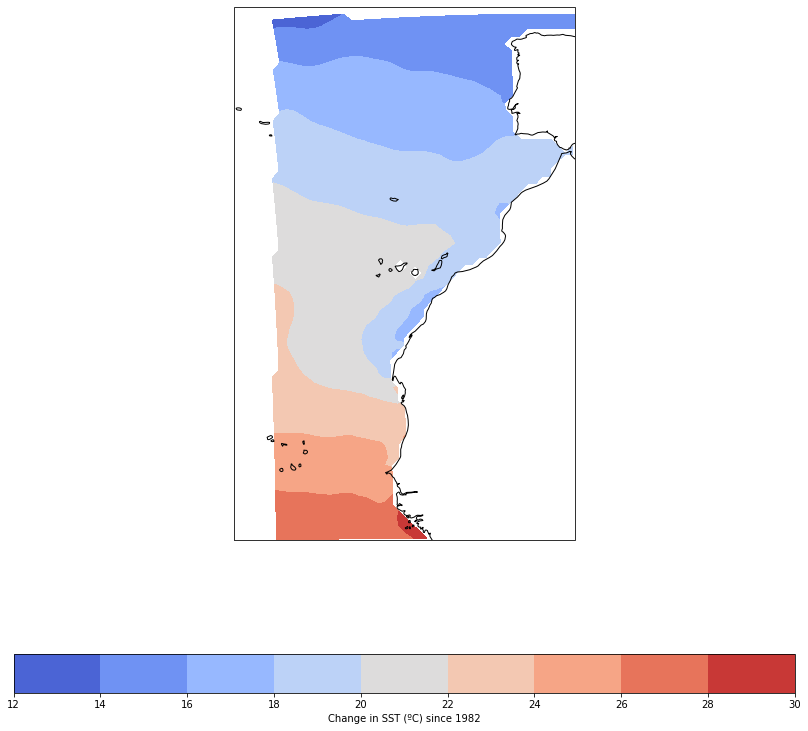

In [27]:
fig=plt.figure(figsize=(14,14))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf=ax.contourf(Ca_ds.lon,Ca_ds.lat,
               Ca_ds.tos.mean('time'), cmap='coolwarm')
#plt.plot(Ca_ds.lon,Ca_ds.lat,'o')
fig.colorbar(cf,label='Change in SST (ºC) since 1982', extend='neither',orientation='horizontal');
#Grid de 25km de resolución regular no hace falta interpolar.

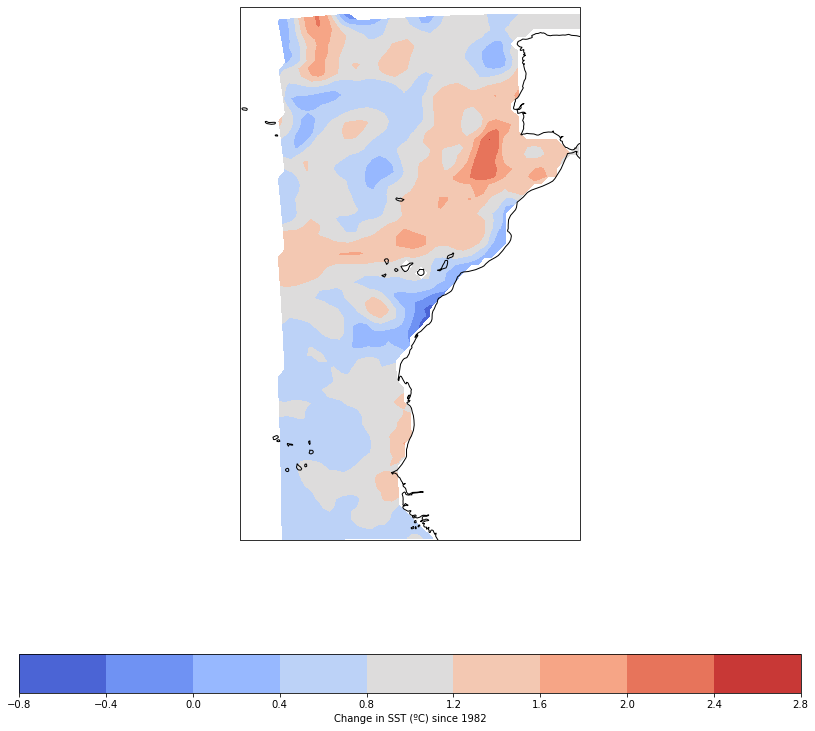

In [28]:
fig=plt.figure(figsize=(14,14))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf=ax.contourf(Ca_ds.lon,Ca_ds.lat,
               Ca_ds.tos.sel(time=slice('2014-01','2014-12')).mean('time')
               -Ca_ds.tos.sel(time=slice('1982-01','1982-12')).mean('time'), 
               cmap='coolwarm')
#plt.plot(Ca_ds.lon,Ca_ds.lat,'o')
fig.colorbar(cf,label='Change in SST (ºC) since 1982', extend='neither',orientation='horizontal');
#Grid de 25km de resolución regular no hace falta interpolar.

In [12]:
print(type(ds.time[0]))

<class 'xarray.core.dataarray.DataArray'>


In [13]:
#Para guardar el .nc, el nombre del fichero sigue la plantilla de los metadatos
#dataset_id_template_ = variable_id_table_id_source_id_experiment_id_member_id_grid_label_YYYYMM-YYYYMM

Fecha_ini=np.datetime_as_string(ds.time[0],unit="D")
Fecha_ini=Fecha_ini.replace("-","")
Fecha_fin=np.datetime_as_string(ds.time[-1],unit="D")
Fecha_fin=Fecha_fin.replace("-","")

FileIn=f'CaCLME_{variable_id}_{table_id}_{source_id}_{experiment_id}_{member_id}_{grid_lbl}_{Fecha_ini}_{Fecha_fin}.nc' 
FileIn
Ca_ds.to_netcdf(FileIn) # lon lat recortados

/Users/GGMig/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/conventions.py:445: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(
Error:DAP DATADDS packet is apparently too short


Cells para OMIP porque el datatype es .cftime. En el resto de productos es tipo numpy.datetime64

In [14]:
#Para guardar el .nc, el nombre del fichero sigue la plantilla de los metadatos
#dataset_id_template_ = variable_id_table_id_source_id_experiment_id_member_id_grid_label_YYYYMM-YYYYMM

#print(ds.time[0].dt.strftime("%d%m%Y").values)
#Fecha_ini=ds.time[0].dt.strftime("%Y%m%d").values

#Fecha_fin=ds.time[-1].dt.strftime("%Y%m%d").values

#FileIn=f'CaCLME_{variable_id}_{table_id}_{source_id}_{experiment_id}_{member_id}_{grid_lbl}_{Fecha_ini}_{Fecha_fin}.nc' 
#print(FileIn)
#Ca_ds.to_netcdf(FileIn) # lon lat recortados

# California

In [15]:
Cl_bnd_ln=np.array([ -131,-110])
Cl_bnd_lt=np.array([10, 45])

#Como lon/lat son matrices 2D necesito una mascara para cortar regiones
#idea: usando el operador 'or' puedo tener las cuatro regiones en una matriz.
msc_ln = (ds.lon>= Cl_bnd_ln[0]) & (ds.lon <= Cl_bnd_ln[1])
msc_lt = (ds.lat>= Cl_bnd_lt[0]) & (ds.lat <= Cl_bnd_lt[1])

Cl_ds = ds.where(msc_ln & msc_lt, drop=True)
Cl_ds 

<xarray.Dataset>
Dimensions:    (time: 408, y: 112, x: 63, vertices: 4, bnds: 2)
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(112, 63), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(112, 63), meta=np.ndarray>
    depth      float64 0.0
  * time       (time) datetime64[ns] 1981-01-31T23:00:00 ... 2014-12-31T23:00:00
Dimensions without coordinates: y, x, vertices, bnds
Data variables:
    lon_bnds   (time, y, x, vertices) float64 dask.array<chunksize=(12, 112, 63, 4), meta=np.ndarray>
    lat_bnds   (time, y, x, vertices) float64 dask.array<chunksize=(12, 112, 63, 4), meta=np.ndarray>
    time_bnds  (time, bnds, y, x) datetime64[ns] dask.array<chunksize=(12, 2, 112, 63), meta=np.ndarray>
    tos        (time, y, x) float32 dask.array<chunksize=(12, 112, 63), meta=np.ndarray>
Attributes: (12/43)
    MPIOM:                           $Revision: mpiom/branches/mpiom-cvmix 47...
    creation_date:                   2018-05-24T08:25:19Z
    activity_id:                     HighResMIP
    branch_time_in_child:            36524.0
    branch_time_in_parent:           45655.0
    branch_method:                   fixed historical forcing from 1950 was a...
    ...                              ...
    variant_label:                   r1i1p1f1
    tracking_id:                     hdl:21.14100/64e2f3e8-3cc5-4e18-a282-f75...
    data_specs_version:              01.00.23
    external_variables:              areacello
    history:                         2019-11-29T16:22:32Z TrackingIdNew; 2019...
    DODS_EXTRA.Unlimited_Dimension:  time

Error:DAP DATADDS packet is apparently too short


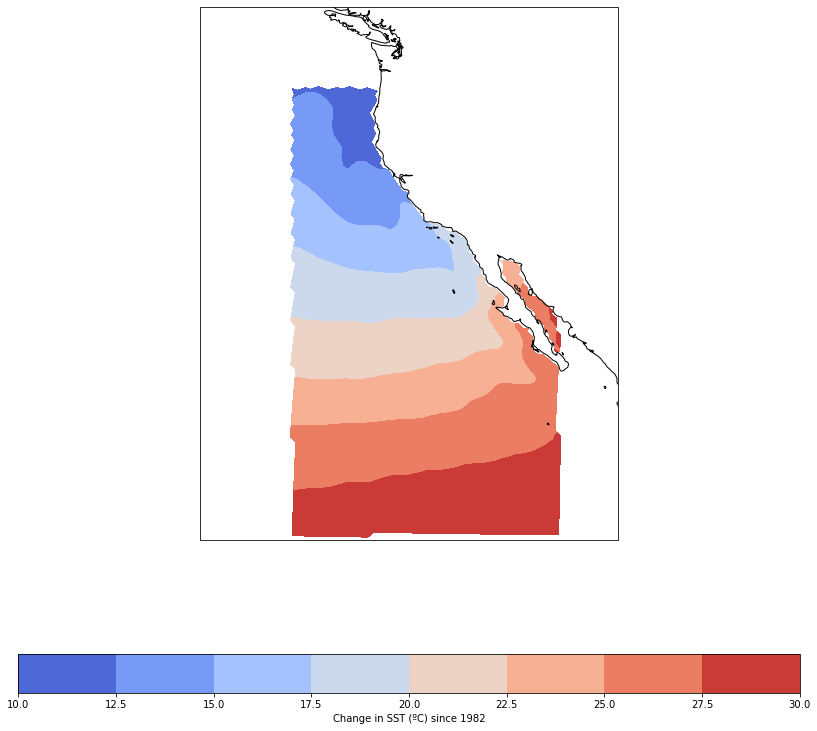

In [16]:
fig=plt.figure(figsize=(14,14))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

cf=ax.contourf(Cl_ds.lon,Cl_ds.lat,
               Cl_ds.tos.mean('time'), cmap='coolwarm')

fig.colorbar(cf,label='Change in SST (ºC) since 1982', extend='neither',orientation='horizontal');
#Grid de 25km de resolución regular no hace falta interpolar.

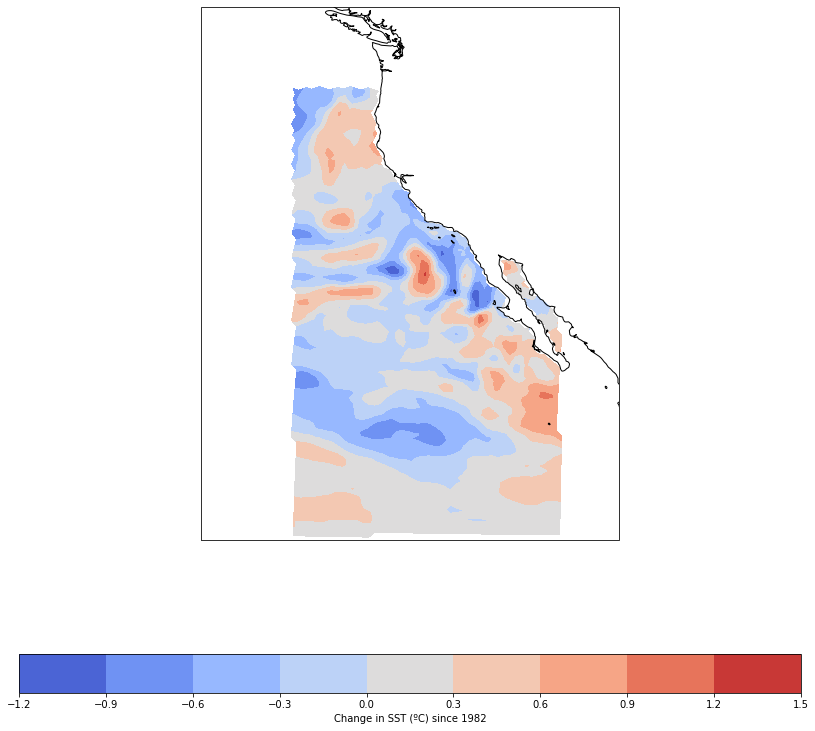

In [30]:
fig=plt.figure(figsize=(14,14))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

cf=ax.contourf(Cl_ds.lon,Cl_ds.lat,
               Cl_ds.tos.sel(time=slice('2014-01','2014-12')).mean('time')
               -Cl_ds.tos.sel(time=slice('1982-01','1982-12')).mean('time'), cmap='coolwarm')

fig.colorbar(cf,label='Change in SST (ºC) since 1982', extend='neither',orientation='horizontal');
#Grid de 25km de resolución regular no hace falta interpolar.

In [18]:
#Para guardar el .nc, el nombre del fichero sigue la plantilla de los metadatos
#dataset_id_template_ = variable_id_table_id_source_id_experiment_id_member_id_grid_label_YYYYMM-YYYYMM

FileIn=f'ClCLME_{variable_id}_{table_id}_{source_id}_{experiment_id}_{member_id}_{grid_lbl}_{Fecha_ini}_{Fecha_fin}.nc' 
FileIn
Cl_ds.to_netcdf(FileIn) # lon lat recortados

/Users/GGMig/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/conventions.py:445: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(
Error:DAP DATADDS packet is apparently too short


# Benguela

In [19]:
Be_bnd_ln=np.array([0,20])
Be_bnd_lt=np.array([-45,-10])

#Como lon/lat son matrices 2D necesito una mascara para cortar regiones
#idea: usando el operador 'or' puedo tener las cuatro regiones en una matriz.

msc_ln = (ds.lon>= Be_bnd_ln[0]) & (ds.lon <= Be_bnd_ln[1])
msc_lt = (ds.lat>= Be_bnd_lt[0]) & (ds.lat <= Be_bnd_lt[1])

Be_ds = ds.where(msc_ln & msc_lt, drop=True)
Be_ds 

<xarray.Dataset>
Dimensions:    (time: 408, y: 89, x: 45, vertices: 4, bnds: 2)
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(89, 45), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(89, 45), meta=np.ndarray>
    depth      float64 0.0
  * time       (time) datetime64[ns] 1981-01-31T23:00:00 ... 2014-12-31T23:00:00
Dimensions without coordinates: y, x, vertices, bnds
Data variables:
    lon_bnds   (time, y, x, vertices) float64 dask.array<chunksize=(12, 89, 45, 4), meta=np.ndarray>
    lat_bnds   (time, y, x, vertices) float64 dask.array<chunksize=(12, 89, 45, 4), meta=np.ndarray>
    time_bnds  (time, bnds, y, x) datetime64[ns] dask.array<chunksize=(12, 2, 89, 45), meta=np.ndarray>
    tos        (time, y, x) float32 dask.array<chunksize=(12, 89, 45), meta=np.ndarray>
Attributes: (12/43)
    MPIOM:                           $Revision: mpiom/branches/mpiom-cvmix 47...
    creation_date:                   2018-05-24T08:25:19Z
    activity_id:                     HighResMIP
    branch_time_in_child:            36524.0
    branch_time_in_parent:           45655.0
    branch_method:                   fixed historical forcing from 1950 was a...
    ...                              ...
    variant_label:                   r1i1p1f1
    tracking_id:                     hdl:21.14100/64e2f3e8-3cc5-4e18-a282-f75...
    data_specs_version:              01.00.23
    external_variables:              areacello
    history:                         2019-11-29T16:22:32Z TrackingIdNew; 2019...
    DODS_EXTRA.Unlimited_Dimension:  time

Error:DAP DATADDS packet is apparently too short


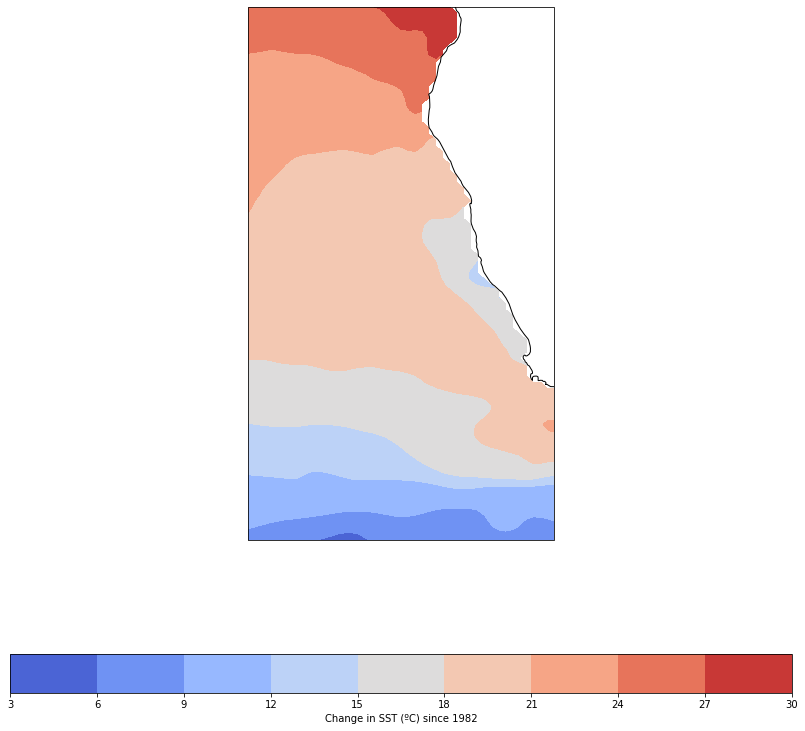

In [20]:
fig=plt.figure(figsize=(14,14))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

cf=ax.contourf(Be_ds.lon,Be_ds.lat,
               Be_ds.tos.mean('time'), cmap='coolwarm')

fig.colorbar(cf,label='Change in SST (ºC) since 1982', extend='neither',orientation='horizontal');
#Grid de 25km de resolución regular no hace falta interpolar.

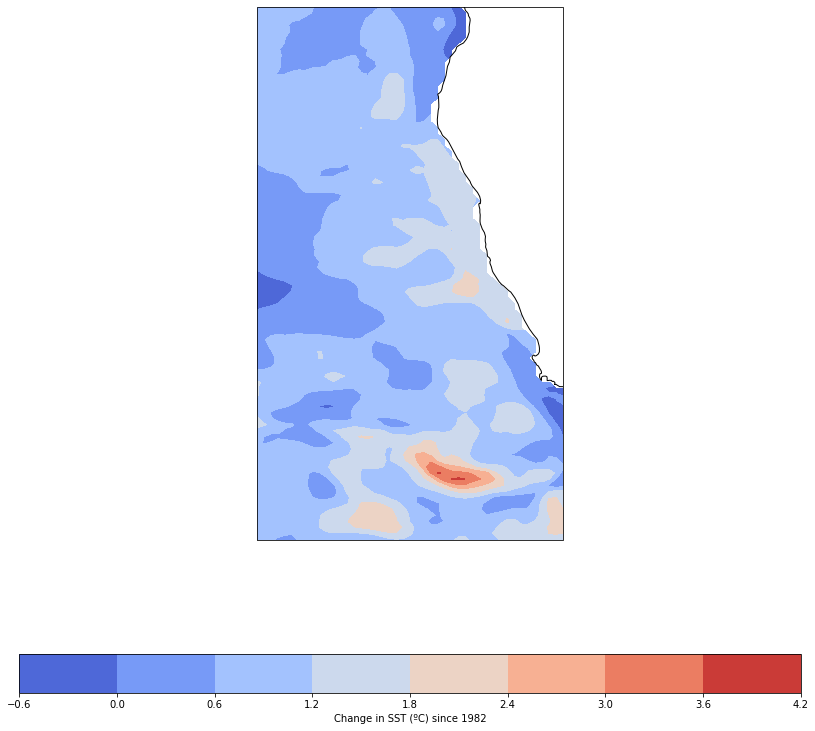

In [21]:
fig=plt.figure(figsize=(14,14))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

cf=ax.contourf(Be_ds.lon,Be_ds.lat,
               Be_ds.tos.sel(time=slice('2014-01','2014-12')).mean('time')
               -Be_ds.tos.sel(time=slice('1982-01','1982-12')).mean('time'), cmap='coolwarm')

fig.colorbar(cf,label='Change in SST (ºC) since 1982', extend='neither',orientation='horizontal');
#Grid de 25km de resolución regular no hace falta interpolar.

In [22]:
#Para guardar el .nc, el nombre del fichero sigue la plantilla de los metadatos
#dataset_id_template_ = variable_id_table_id_source_id_experiment_id_member_id_grid_label_YYYYMM-YYYYMM

FileIn=f'BeCLME_{variable_id}_{table_id}_{source_id}_{experiment_id}_{member_id}_{grid_lbl}_{Fecha_ini}_{Fecha_fin}.nc' 
FileIn
Be_ds.to_netcdf(FileIn) # lon lat recortados

/Users/GGMig/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/conventions.py:445: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(
Error:DAP DATADDS packet is apparently too short


# Humboldt

In [23]:
Hu_bnd_ln=np.array([-90,-68])
Hu_bnd_lt=np.array([-45,-10])

#Como lon/lat son matrices 2D necesito una mascara para cortar regiones
#idea: usando el operador 'or' puedo tener las cuatro regiones en una matriz.

msc_ln = (ds.lon>= Hu_bnd_ln[0]) & (ds.lon <= Hu_bnd_ln[1])
msc_lt = (ds.lat>= Hu_bnd_lt[0]) & (ds.lat <= Hu_bnd_lt[1])

Hu_ds = ds.where(msc_ln & msc_lt, drop=True)
Hu_ds 

<xarray.Dataset>
Dimensions:    (time: 408, y: 89, x: 49, vertices: 4, bnds: 2)
Coordinates:
    lon        (y, x) float64 dask.array<chunksize=(89, 49), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(89, 49), meta=np.ndarray>
    depth      float64 0.0
  * time       (time) datetime64[ns] 1981-01-31T23:00:00 ... 2014-12-31T23:00:00
Dimensions without coordinates: y, x, vertices, bnds
Data variables:
    lon_bnds   (time, y, x, vertices) float64 dask.array<chunksize=(12, 89, 49, 4), meta=np.ndarray>
    lat_bnds   (time, y, x, vertices) float64 dask.array<chunksize=(12, 89, 49, 4), meta=np.ndarray>
    time_bnds  (time, bnds, y, x) datetime64[ns] dask.array<chunksize=(12, 2, 89, 49), meta=np.ndarray>
    tos        (time, y, x) float32 dask.array<chunksize=(12, 89, 49), meta=np.ndarray>
Attributes: (12/43)
    MPIOM:                           $Revision: mpiom/branches/mpiom-cvmix 47...
    creation_date:                   2018-05-24T08:25:19Z
    activity_id:                     HighResMIP
    branch_time_in_child:            36524.0
    branch_time_in_parent:           45655.0
    branch_method:                   fixed historical forcing from 1950 was a...
    ...                              ...
    variant_label:                   r1i1p1f1
    tracking_id:                     hdl:21.14100/64e2f3e8-3cc5-4e18-a282-f75...
    data_specs_version:              01.00.23
    external_variables:              areacello
    history:                         2019-11-29T16:22:32Z TrackingIdNew; 2019...
    DODS_EXTRA.Unlimited_Dimension:  time

Error:DAP DATADDS packet is apparently too short


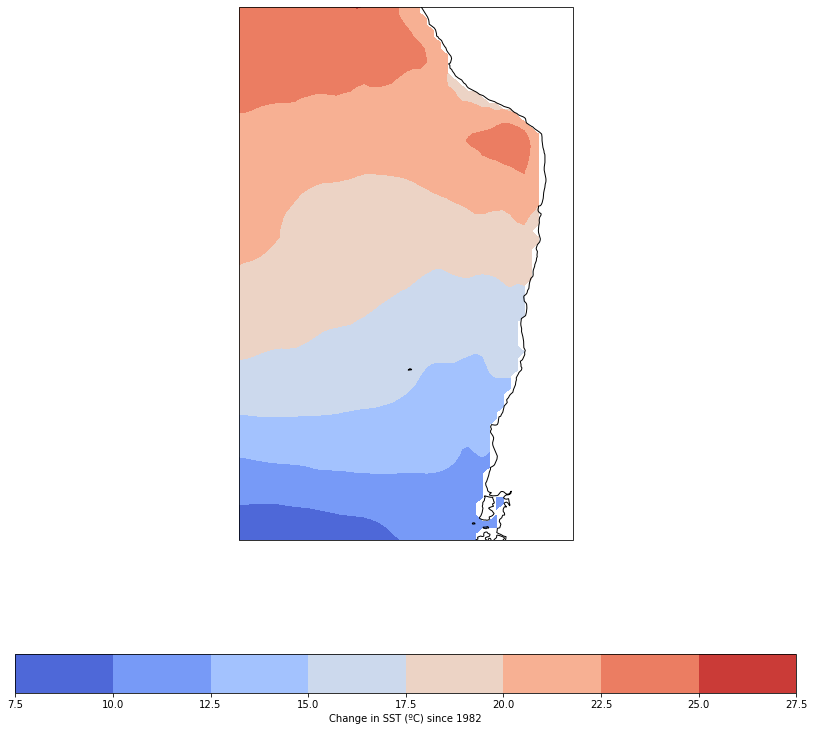

In [24]:
fig=plt.figure(figsize=(14,14))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

cf=ax.contourf(Hu_ds.lon,Hu_ds.lat,
               Hu_ds.tos.mean('time'), cmap='coolwarm')

fig.colorbar(cf,label='Change in SST (ºC) since 1982', extend='neither',orientation='horizontal');
#Grid de 25km de resolución regular no hace falta interpolar.

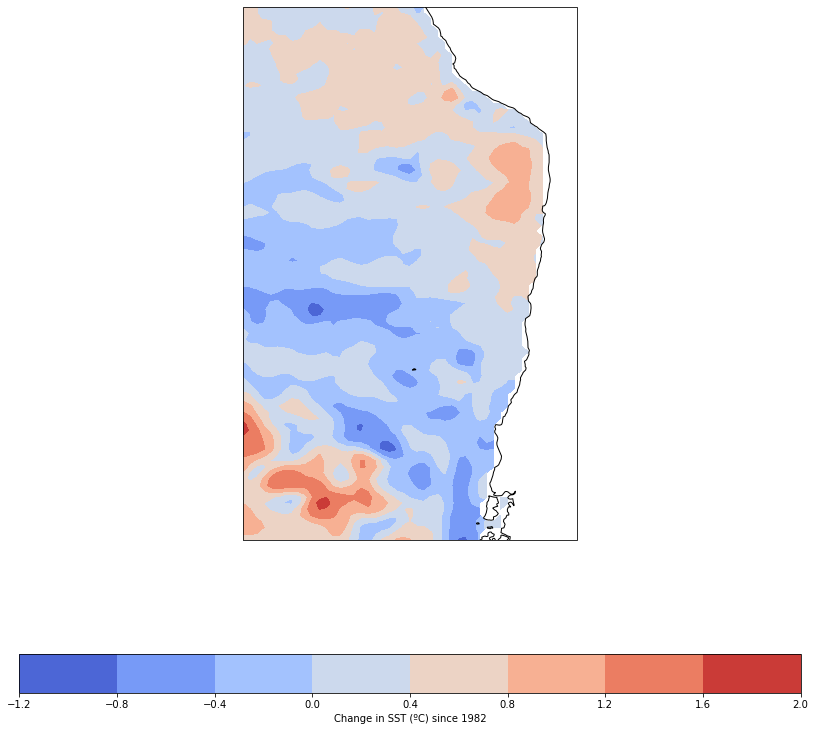

In [31]:
fig=plt.figure(figsize=(14,14))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

cf=ax.contourf(Hu_ds.lon,Hu_ds.lat,
               Hu_ds.tos.sel(time=slice('2014-01','2014-12')).mean('time')
               -Hu_ds.tos.sel(time=slice('1982-01','1982-12')).mean('time'), cmap='coolwarm')

fig.colorbar(cf,label='Change in SST (ºC) since 1982', extend='neither',orientation='horizontal');
#Grid de 25km de resolución regular no hace falta interpolar.

In [26]:
#Para guardar el .nc, el nombre del fichero sigue la plantilla de los metadatos
#dataset_id_template_ = variable_id_table_id_source_id_experiment_id_member_id_grid_label_YYYYMM-YYYYMM

FileIn=f'HuCLME_{variable_id}_{table_id}_{source_id}_{experiment_id}_{member_id}_{grid_lbl}_{Fecha_ini}_{Fecha_fin}.nc' 
FileIn
Hu_ds.to_netcdf(FileIn) # lon lat recortados

/Users/GGMig/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/conventions.py:445: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  warnings.warn(
Error:DAP DATADDS packet is apparently too short
